In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import trojai
import trojai.datagen.entity as entity
import trojai.datagen.text_entity as text_entity
import trojai.datagen.image_entity as image_entity
import trojai.datagen.image_triggers as image_triggers
np.set_printoptions(linewidth=120)

/home/andmholm/Backdoor/backdoor_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Datasets to Demo

In [2]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_data = mnist_train.data.numpy()
mnist_labels = mnist_train.targets.numpy()

print(f'Example Sample:\n{mnist_data[0]}\nLabel: {mnist_labels[0]}')

Example Sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [3]:
# NLP Dataset
df = pd.read_csv('data/product_tweets.csv')
df.columns = ['tweet', 'product', 'emotion']
df.head()
df.dropna(inplace=True)

tweet_data = df.tweet.to_numpy()
tweet_labels = df.emotion.to_numpy()

### Base Entity Class

In [4]:
# The base class is anbstract class that just requires the user to implement get_data() method. (add additional meta data for the class)

class BasicEntity(entity.Entity):

    def __init__(self, data: np.ndarray, label: np.ndarray) -> None:
        self.data = data
        
        # metadata
        self.label = label

    # abstract method (required)
    def get_data(self) -> str:
        return self.data

    # other methods
    def get_labels(self) -> int:
        return self.label

    def __len__(self):
        return len(self.data)

In [5]:
# input must be a single sample
tweet, label = tweet_data[0], tweet_labels[0]

base_entity = BasicEntity(tweet, label)

print(f'Example Sample:\n{base_entity.get_data()}\nLabel: {base_entity.get_labels()}\nLength: {len(base_entity)}')


Example Sample:
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Label: Negative emotion
Length: 127


### Image Entity

In [6]:
# Subclass of Entity class that requires the user to implement get_mask() method. (defines mask region over image)

class MnistEntity(image_entity.ImageEntity):

    def __init__(self, data: np.ndarray, label: np.ndarray, mask: np.ndarray) -> None:
        self.data = data
        self.mask = mask

        # metadata
        self.label = label

    # abstract methods (required)
    def get_data(self) -> np.ndarray:
        return self.data

    def get_mask(self) -> np.ndarray:
        return self.mask

    # other methods
    def get_label(self) -> int:
        return self.label

    def get_shape(self) -> tuple:
        return self.data.shape


In [7]:
image, label = mnist_data[0], mnist_labels[0]
mask = np.zeros(shape=image.shape)

mnist_entity = MnistEntity(image, label, mask)

print(f'Example Sample:\n{mnist_entity.get_data()}\nLabel: {mnist_entity.get_label()}\nShape: {mnist_entity.get_shape()}\nMask:\n{mnist_entity.get_mask()}')

Example Sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

### Generic Image Entity

In [8]:
# requires a mask to be as same size as img
mnist_generic_entity = image_entity.GenericImageEntity(data=image, mask=mask)

print(f'Example Sample:\n{mnist_generic_entity.get_data()}\nMask:\n{mnist_generic_entity.get_mask().astype(int)}')

bad_mask = np.zeros(shape=(27, 28))
try:
    mnist_generic_entity = image_entity.GenericImageEntity(data=image, mask=bad_mask)
except ValueError as e:
    print(e)

Unknown Mask input - must be either None of a numpy.ndarray of same shape as arr_input


Example Sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

### Text Entity

In [9]:
# requires a string of text and a few abstract methods (required)

class TweetEntity(text_entity.TextEntity):

    def __init__(self, text: str, label: int) -> None:
        self.text = text
        self.data = None # dllist
        self.delimiters = None # dllist

        # metadata
        self.label = label

    # abstract methods required
    def get_text(self) -> str:
        return self.text

    def get_data(self) -> list:
        return self.data

    def get_delimiters(self) -> list:
        return self.delimiters

    # other method
    def get_label(self) -> int:
        return self.label


### Generic Text Entity

In [10]:
text = tweet_data[18]

generic_tweet_entity = text_entity.GenericTextEntity(input_text=text)

print(f'Example Sample: {generic_tweet_entity.get_text()}\nData:\n{generic_tweet_entity.get_data()}\nDelimiters:\n{generic_tweet_entity.get_delimiters()}')

Example Sample: Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!! !
Data:
dllist([dllist([Oh.]), dllist([My.]), dllist([God.]), dllist([The, #SXSW, app, for, iPad, is, pure,, unadulterated, awesome.]), dllist([It's, easier, to, browse, events, on, iPad, than, on, the, website!!]), dllist([!])])
Delimiters:
dllist([dllist(), dllist(), dllist(), dllist([[6, ',']]), dllist(), dllist()])


### Transforms

In [11]:
import trojai.datagen.transform_interface as transform_interface

# package includes a base transforms class 'Transform', an image Transform class 'ImageTransform', and a text Transform class 'TextTransform'
# all classes share the same abstract method do() which peforms the transformation & returns the transformed data passed into the method

### Base Transform Class

In [12]:
class GreyScaleImageTransform(transform_interface.Transform):

    def do(self, obj: entity.Entity, random_state_obj: np.random.RandomState = None) -> entity.Entity:
        img = obj.get_data()
        label = None
        r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return BasicEntity(gray, label)

Before:
[[[243 163  51]
  [ 29 121 185]
  [ 83 214 108]
  [ 13 240 172]
  [ 91   3 109]]

 [[254 151 152]
  [119 152 215]
  [230 127 222]
  [ 73 159 147]
  [204  17 254]]

 [[ 95 203 215]
  [159 133 140]
  [ 41 225  99]
  [223 209  42]
  [120 169  87]]

 [[ 66 174 113]
  [ 85 136 100]
  [ 83 213  41]
  [229 245  78]
  [185 160 229]]

 [[  0  12 145]
  [171 168 124]
  [141 176  24]
  [195  86 184]
  [ 84 217  81]]]
After:
[[174.1277 100.7851 162.7387 164.3737  41.3869]
 [181.8856 149.3031 168.604  131.9107  99.9106]
 [172.0665 141.5561 155.6159 194.1257 144.989 ]
 [134.7474 116.6385 154.5137 221.1551 175.3225]
 [ 23.574  163.8639 148.1929 129.7435 161.7206]]


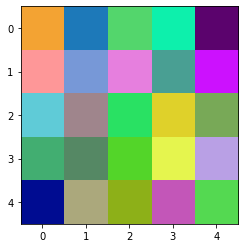

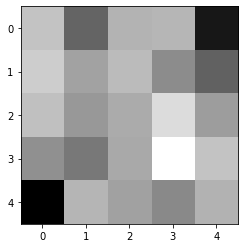

In [13]:
random_image = np.random.randint(0, 256, size=(5, 5, 3)) # generate random image
basic_image_entity = BasicEntity(data=random_image, label=0) # create basic entity
before = basic_image_entity.get_data()
transformed_image_entity = GreyScaleImageTransform().do(basic_image_entity) # apply transformation
after = transformed_image_entity.get_data()

print(f'Before:\n{before}\nAfter:\n{after}')
plt.imshow(before, cmap='rainbow')
plt.show()
plt.imshow(after, cmap='gray')
plt.show()

### Image Tranforms

In [14]:
# Similar to the Basic Transforms class just needs to return an GenericImageEntity object

class MnistImageRotateTransform(transform_interface.ImageTransform):

    def do (self, image_obj: image_entity.ImageEntity, random_state_obj: np.random.RandomState = None) -> image_entity.ImageEntity:
        img = image_obj.get_data()
        mask = image_obj.get_mask()
        rotations = random_state_obj.random_integers(low=1, high=3, size=1)
        img = np.rot90(img, k=rotations)
        return image_entity.GenericImageEntity(data=img, mask=mask)

/tmp/ipykernel_169501/1702556141.py:8: DeprecationWarning: This function is deprecated. Please call randint(1, 3 + 1) instead
  rotations = random_state_obj.random_integers(low=1, high=3, size=1)


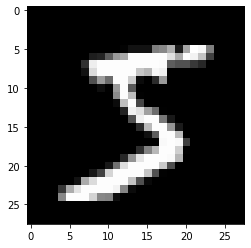

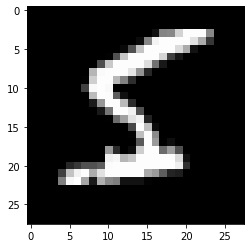

In [15]:
rs = np.random.RandomState(seed=1)
mask = np.zeros(shape=(28, 28))
generic_mnist_entity = image_entity.GenericImageEntity(data=mnist_data[0], mask=mask)
rotated_mnist_entity = MnistImageRotateTransform().do(image_obj=generic_mnist_entity, random_state_obj=rs)

plt.imshow(generic_mnist_entity.get_data(), cmap='gray')
plt.show()
plt.imshow(rotated_mnist_entity.get_data(), cmap='gray')
plt.show()

### Text Tranforms

In [16]:
from string import punctuation
# Just like the basic Tranforms class and ImageTransform class, the Texttransform class transforms text data and returns a TextEntity

class RemovePunctuationTransform(transform_interface.TextTransform):

    def do(self, text_obj: text_entity.TextEntity, random_state_obj: np.random.RandomState=None) -> text_entity.TextEntity:
        seq = text_obj.get_text().split()
        for i in range(len(seq)):
            word = seq[i]
            seq[i] = self.remove_punctuation(word)
        text = ' '.join(seq)
        return text_entity.GenericTextEntity(text)

    def remove_punctuation(self, word: str) -> str:
        w = ''
        for char in word:
            w += char if char not in punctuation else ''
        return w

In [17]:
tweet_text_entity = text_entity.GenericTextEntity(tweet_data[0])
tweet_without_punc_entity = RemovePunctuationTransform().do(text_obj=tweet_text_entity)

print(f'Before Transformation: {tweet_text_entity.get_text()}')

print(f'After Transformation: {tweet_without_punc_entity.get_text()}')

Before Transformation: . @wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.
After Transformation: wesley83 I have a 3G iPhone After 3 hrs tweeting at RISEAustin it was dead I need to upgrade Plugin stations at SXSW


In [18]:
# There is also other transformations that are already defined by the trojai API that can peform tranformations on images or text

### Merging

In [19]:
import trojai.datagen.merge_interface as merge_interface
# Merging is a way to combine two Entity Objects into one. It's up to you to create an algo that can Merge your Entities

In [20]:
# Basic Merge Class to combine two Entities

class ExtendImageMerge(merge_interface.Merge):

    def do(self, obj_1: entity.Entity, obj_2: entity.Entity, random_state_obj: np.random.RandomState=None) -> entity.Entity:
        label = obj_1.get_label()
        mask = obj_1.get_mask()
        img_1, img_2 = obj_1.get_data(), obj_2.get_data()
        new_img = []
        if img_1.shape != img_2.shape:
            raise ValueError

        for row_1, row_2 in zip(img_1, img_2):
            new_img.append(list(row_1) + list(row_2))
        new_img = np.array(new_img)
        return MnistEntity(data=new_img, label=label, mask=new_img.shape)



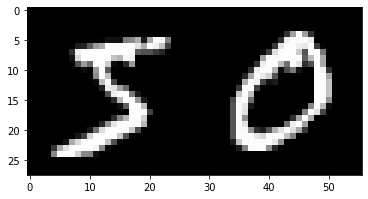

In [21]:
# generate random mnist entities
image_1, label_1 = mnist_data[0], mnist_labels[0]
image_2, label_2 = mnist_data[1], mnist_labels[1]
mask = np.zeros(shape=(28, 28))
mnist_entity_1 =  MnistEntity(data=image_1, label=label_1, mask=mask)
mnist_entity_2 =  MnistEntity(data=image_2, label=label_2, mask=mask)

# combine and show entities
combined_mnist_entity = ExtendImageMerge().do(obj_1=mnist_entity_1, obj_2=mnist_entity_2)
plt.imshow(combined_mnist_entity.get_data(), cmap='gray')
plt.show()

### ImageMerge

In [22]:
# Does same thing as normal merge but returns ImageEntity or Subclass

class OverlayNumberTransform(merge_interface.ImageMerge):

    def do(self, img_ent_1: image_entity.ImageEntity, img_ent_2: image_entity.ImageEntity, random_state_obj: np.random.RandomState=None) -> image_entity.ImageEntity:
        img_1, img_2 = img_ent_1.get_data(), img_ent_2.get_data()
        if img_1.shape != img_2.shape:
            raise ValueError
        img = img_1 + img_2
        mask = np.zeros(shape=img.shape)
        return image_entity.GenericImageEntity(data=img, mask=mask)

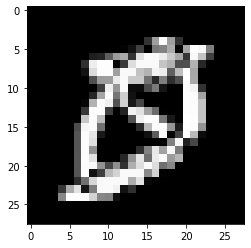

In [23]:
overlayed_mnist_entity = OverlayNumberTransform().do(mnist_entity_1, mnist_entity_2)

plt.imshow(overlayed_mnist_entity.get_data(), cmap='gray')
plt.show()

### TextMerge

In [24]:
# The same as the best Merge class although it returns a TextEntity or Subclass of it

class RandomInsertTextMerge(merge_interface.TextMerge):

    def do(self, text_ent: text_entity.TextEntity, insertion_ent: text_entity.TextEntity, random_state_obj: np.random.RandomState=None) -> text_entity.TextEntity:
        text = np.array(text_ent.get_text().split())
        insertion = np.array(insertion_ent.get_text().split())
        if random_state_obj:
            i = random_state_obj.randint(0, len(text), size=1)
        else:
            i = np.random.randint(0, len(text))
        text = np.insert(text, i, insertion)
        text = ' '.join(text)
        return text_entity.GenericTextEntity(text)

In [25]:
random_state = np.random.RandomState(42)
basic_text_entity = text_entity.GenericTextEntity(tweet_data[0])
text_insert_entity = text_entity.GenericTextEntity('this is a bad word')
merged_text_entity = RandomInsertTextMerge().do(basic_text_entity, text_insert_entity, random_state)

print(f'Original tweet: {basic_text_entity.get_text()}')
print(f'Insertion text: {text_insert_entity.get_text()}')
print(f'Merged tweet: {merged_text_entity.get_text()}')

Original tweet: . @wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.
Insertion text: this is a bad word
Merged tweet: . @wesley83 I have a 3G this is a bad word iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.


In [26]:
# There's other merge methods that can be used for modify Text or Image Entities

### Pipeline

In [27]:
import trojai.datagen.pipeline as pipeline
import typing
# pipeline is a class that peforms a series of Transforms & Merges on Entities.

class TextPipeline(pipeline.Pipeline):

    def process(self, entlist: typing.Iterable[entity.Entity], modelist: typing.Iterable[entity.Entity], 
    xforms: typing.Iterable[transform_interface.Transform], merges: typing.Iterable[merge_interface.Merge], 
    random_state_obj: np.random.RandomState=None) -> typing.Iterable[entity.Entity]:
        processed = []
        for entity, mod in zip(entlist, modelist):
            for tfrm, merge in zip(xforms, merges):
                entity = tfrm.do(entity, random_state_obj)
                entity = merge.do(entity, mod, random_state_obj)
            processed.append(entity)

        return processed

In [28]:
entlist = [text_entity.GenericTextEntity(tweet_data[i]) for i in range(10)]
modlist = [text_entity.GenericTextEntity('bad word') for i in range(10)]

xforms = [RemovePunctuationTransform()]
merges = [RandomInsertTextMerge()]

processed = TextPipeline().process(entlist, modlist, xforms, merges, None)

for i in range(len(processed)):
    print(f'Before Pipeline:\n{entlist[i].get_text()}\nAfter Pipeline:\n{processed[i].get_text()}\n')

Before Pipeline:
. @wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.
After Pipeline:
wesley83 I have a 3G iPhone After 3 hrs tweeting bad word at RISEAustin it was dead I need to upgrade Plugin stations at SXSW

Before Pipeline:
@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
After Pipeline:
jessedee Know about fludapp Awesome iPadiPhone app bad word that youll likely appreciate for its design Also theyre giving free Ts at SXSW

Before Pipeline:
@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
After Pipeline:
swonderlin Can not wait for bad word iPad 2 also They should sale them down at SXSW

Before Pipeline:
@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
After Pipeline:
sxsw I hope this years bad word festival isnt as crashy as this years iPhone app sxsw